# ACTPol Likelihood Analysis (DR4 release)

## Preamble

This notebook make use of [GetDist](https://getdist.readthedocs.io/en/latest/) python package to plot and to analyse MCMC samples.



In [78]:
import os
import matplotlib.pyplot as plt
import numpy as np

Print versions used



In [79]:
import getdist
import matplotlib

getdist.chains.print_load_details = False

print("     Numpy :", np.__version__)
print("Matplotlib :", matplotlib.__version__)
print("   GetDist :", getdist.__version__)

     Numpy : 1.20.0
Matplotlib : 3.3.3
   GetDist : 1.1.2


We will use the `cobaya_utilities` module to ease some plotting like how the chains evolve

In [80]:
!pip install git+https://github.com/xgarrido/cobaya_utilities.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/xgarrido/cobaya_utilities.git to /tmp/pip-req-build-as1zcw7h
  Running command git clone -q https://github.com/xgarrido/cobaya_utilities.git /tmp/pip-req-build-as1zcw7h
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


## Definitions

Define CMB & nuisance parameter names.



In [111]:
cosmo_params = ["cosmomc_theta", "logA", "ns", "ombh2", "omch2", "H0", "tau"]
nuisance_params = [f"yp{i}" for i in range(15)]

Set a dictionnary holding the path to the MCMC chains and its name

In [120]:
mcmc_samples = {"ACTPol - TE+EE": "data/te_ee", "ACTPol - TT+TE+EE": "data/tt_te_ee"}

## MCMC chains

Let's plot the chains size

In [121]:
from cobaya_utilities.tools import print_chains_size

print_chains_size(mcmc_samples.values(), list(mcmc_samples.keys()))

,mcmc 1,mcmc 2,mcmc 3,mcmc 4,total
ACTPol - TE+EE,40948,41017,41503,38862,162330
ACTPol - TT+TE+EE,72482,50366,48603,55622,227073


Have a look at how chains evolve with time and check convergence or not.



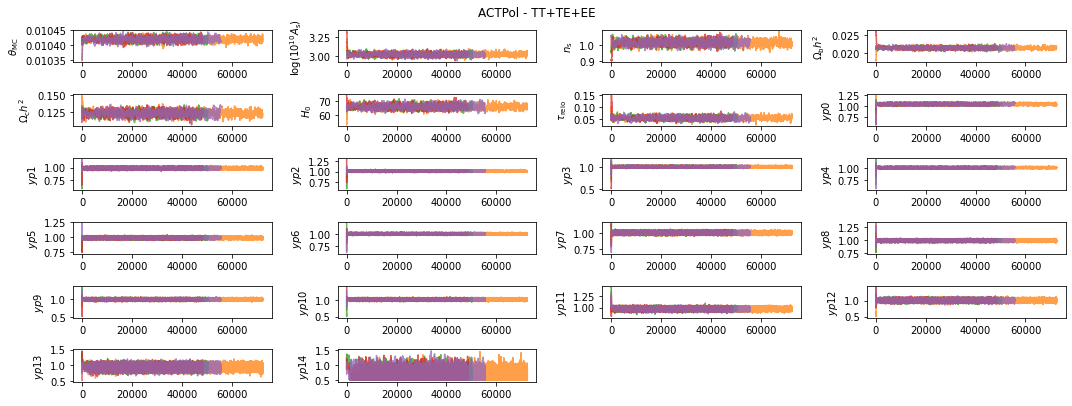

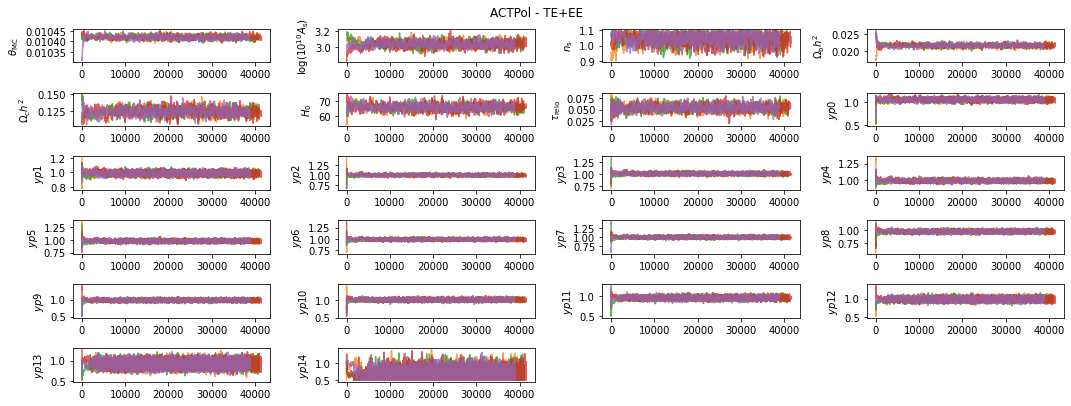

In [114]:
from cobaya_utilities.tools import plot_chains

for k, v in mcmc_samples.items():
    params = cosmo_params + nuisance_params
    plot_chains(v, params=params, title=k, ncol=4)

Let's plot also the Gelman $R-1$ parameter and acceptance rate progress

In [ ]:
from cobaya_utilities.tools import plot_progress

plot_progress(mcmc_samples.values(), list(mcmc_samples.keys()))

## MCMC distributions



Define global plot settings

In [9]:
from getdist.plots import GetDistPlotSettings

plot_settings = GetDistPlotSettings()
plot_settings.num_plot_contours = 3
plot_settings.solid_colors = "tab10"
plot_settings.line_styles = "tab10"
plot_settings.legend_fontsize = 15

Load MCMC samples



In [122]:
from getdist import loadMCSamples

samples = [
    loadMCSamples(os.path.join(path, "mcmc"), settings={"ignore_rows": 0.4})
    for path in mcmc_samples.values()
]

Plot posteriors distributions of CMB parameters



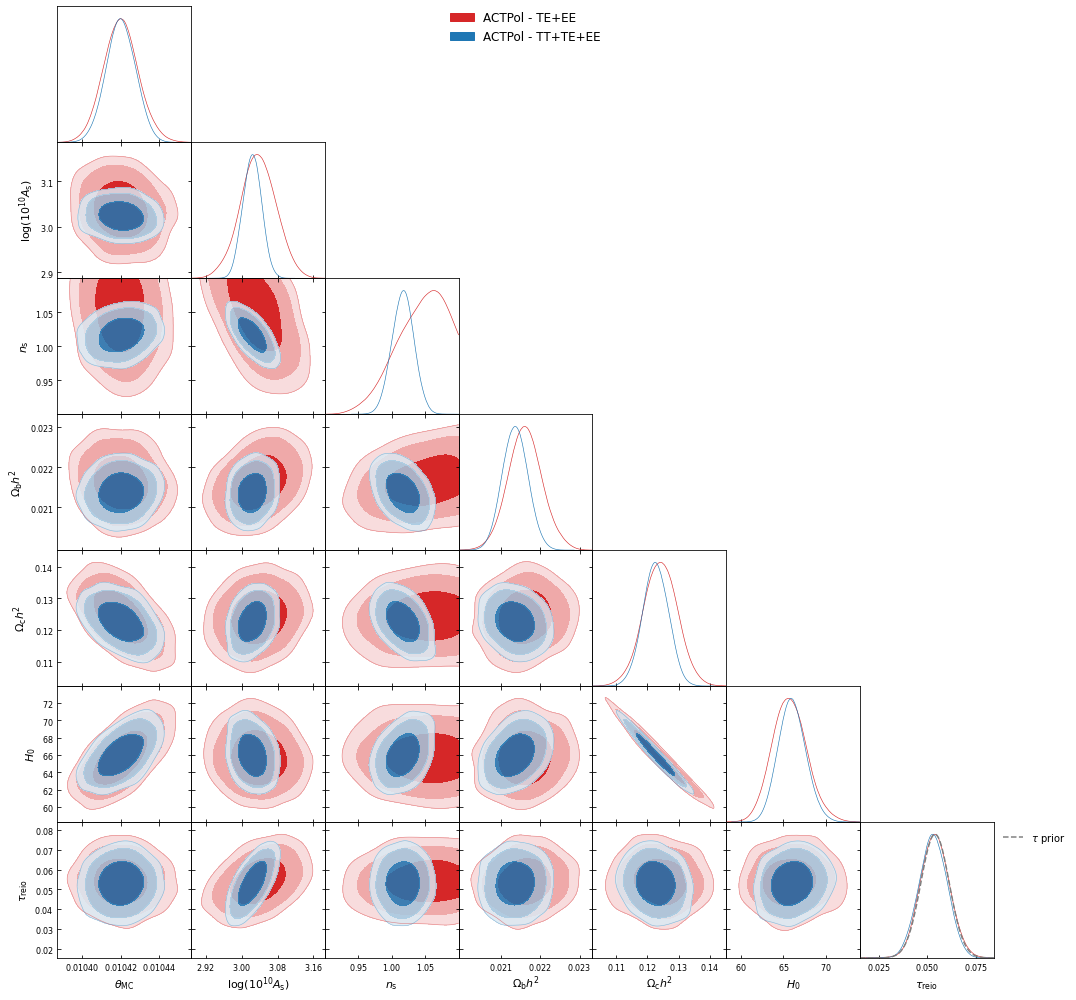

In [123]:
from getdist import plots

g = plots.get_subplot_plotter(settings=plot_settings)
colors = ["tab:red", "tab:blue", "tab:orange"]
g.triangle_plot(
    samples,
    cosmo_params,
    filled=True,
    legend_labels=mcmc_samples.keys(),
    colors=colors,
    diag1d_kwargs={"colors": colors},
)
# Show prior on tau
from scipy.stats import norm

ax = g.subplots[-1, -1]
xmin, xmax, ymin, ymax = ax.axis()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, 0.054, 0.0073)

ax.plot(x, y / np.max(y), color="gray", ls="--", label=r"$\tau$ prior")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1));

Plot posteriors distributions of nuisance parameters



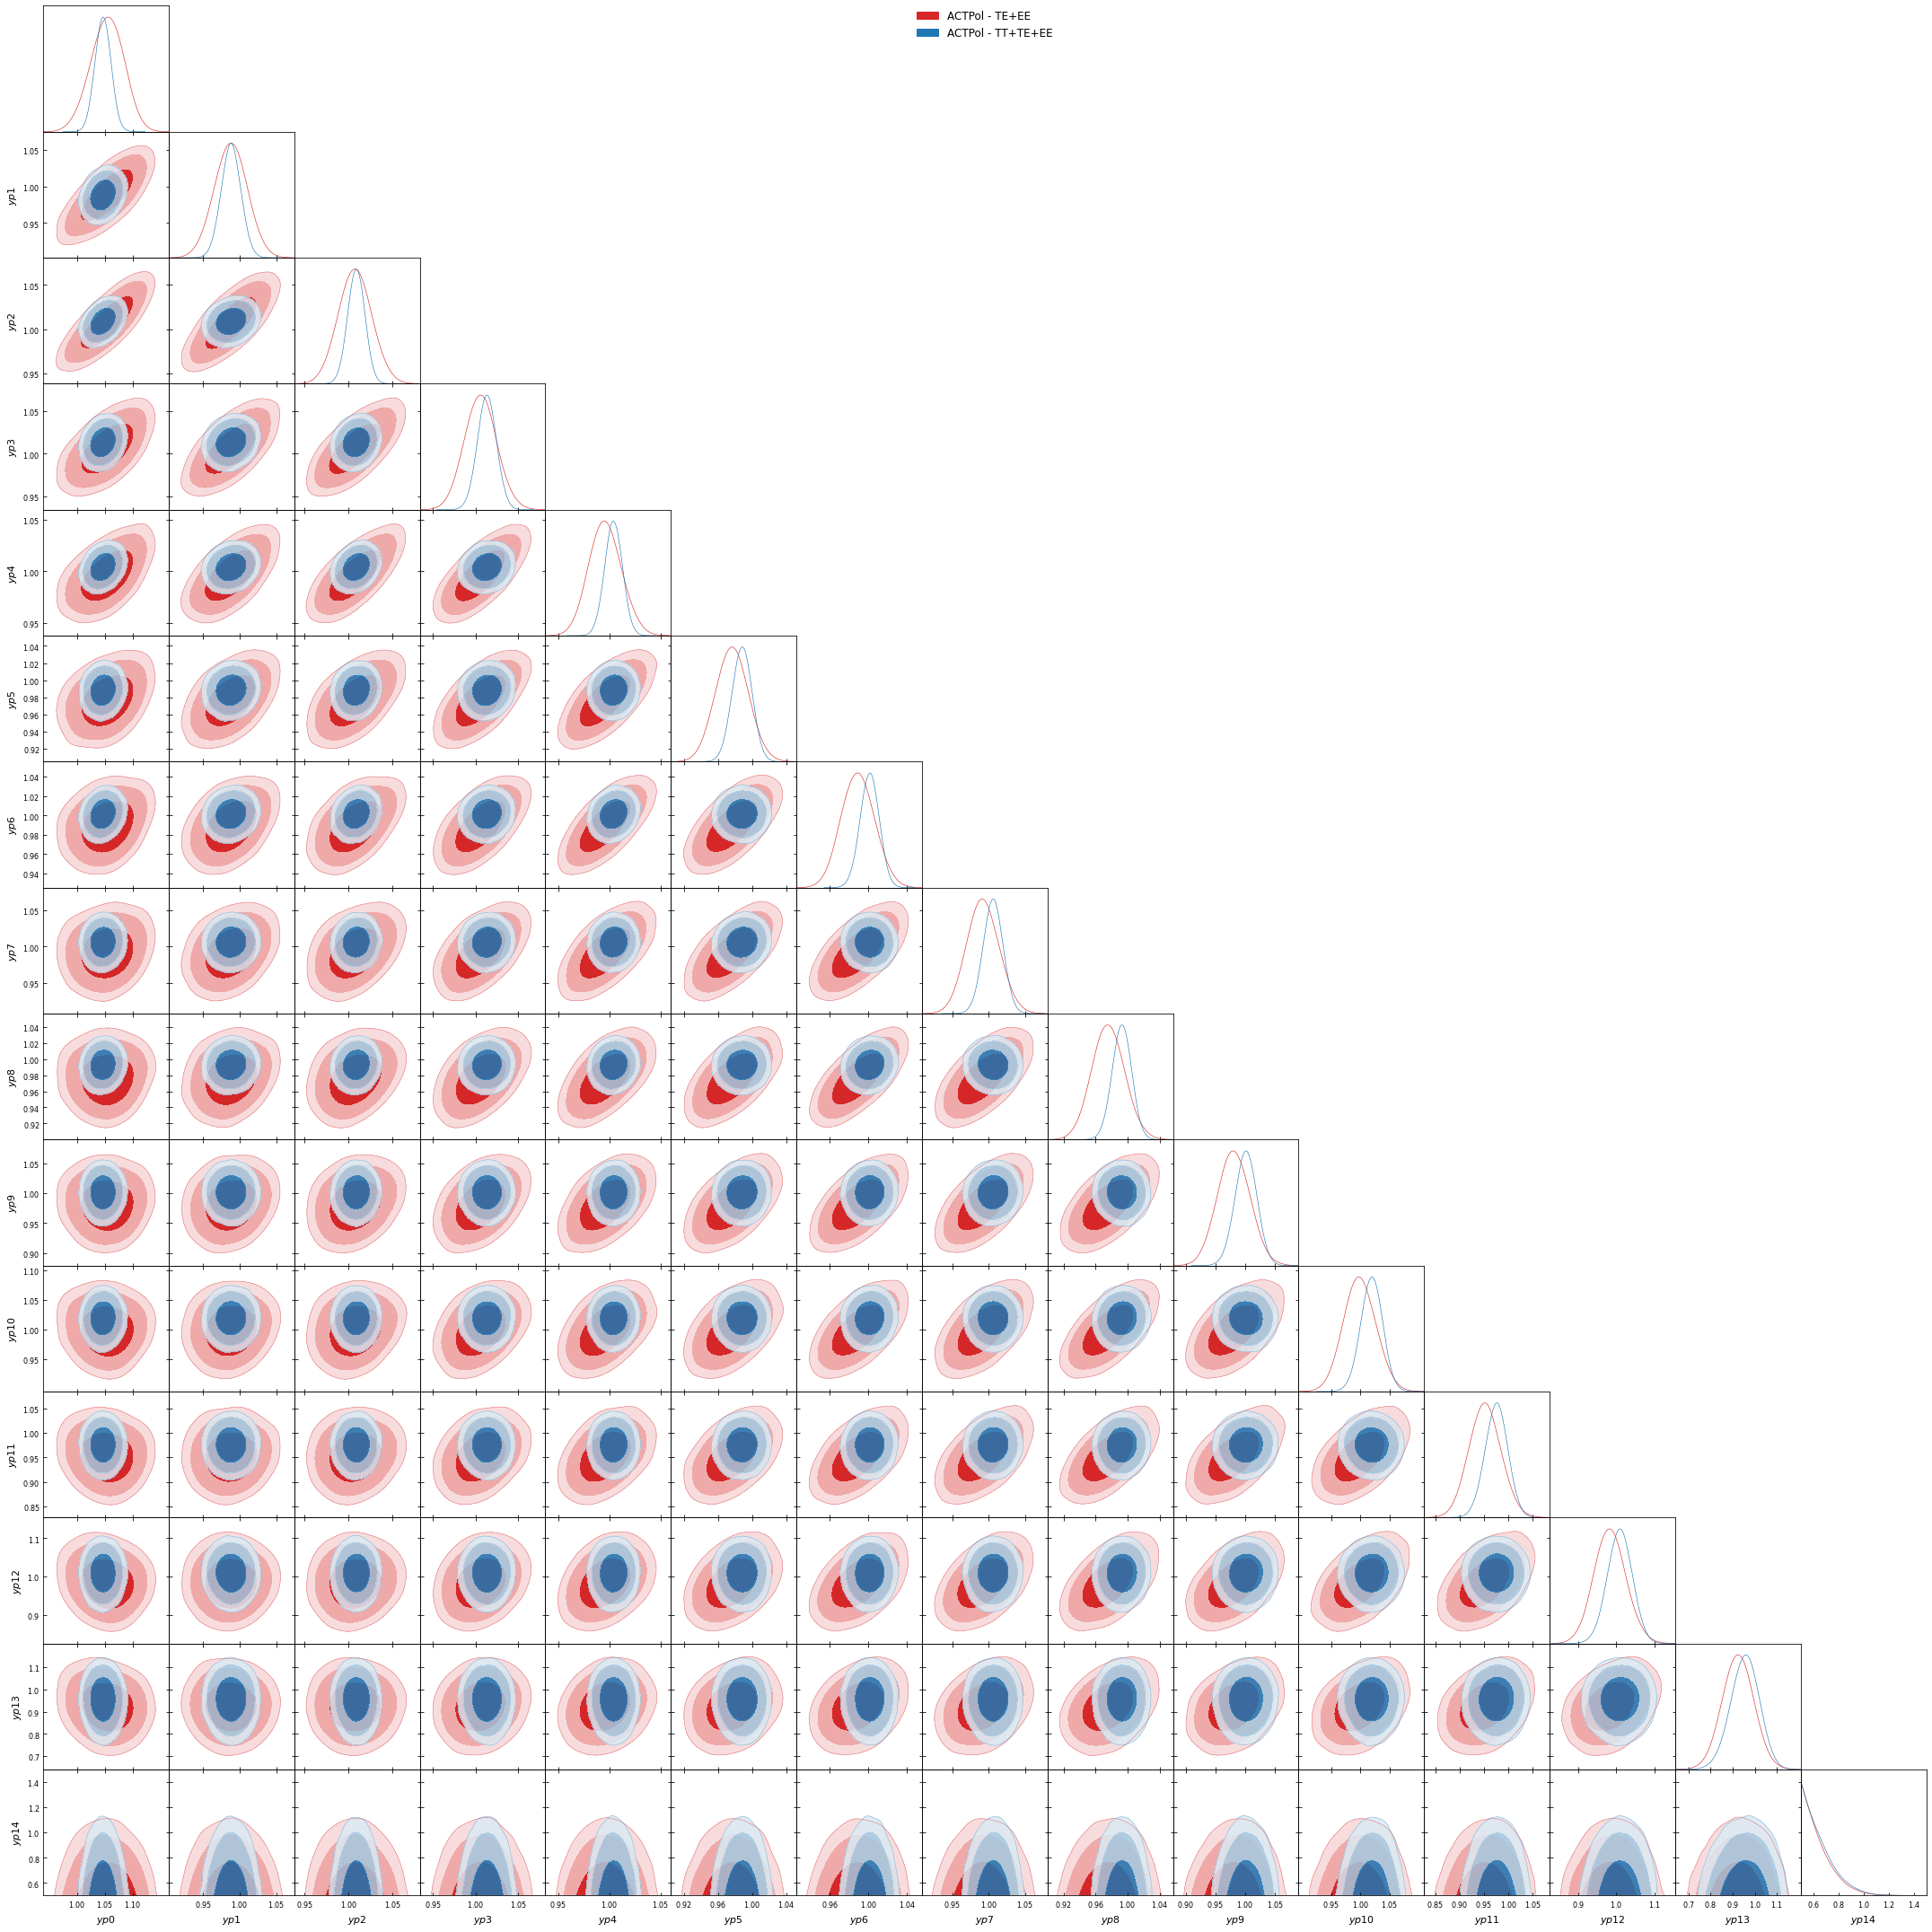

In [124]:
g.triangle_plot(
    samples,
    nuisance_params,
    filled=True,
    legend_labels=mcmc_samples.keys(),
    colors=colors,
    diag1d_kwargs={"colors": colors},
)

### Correlation plot



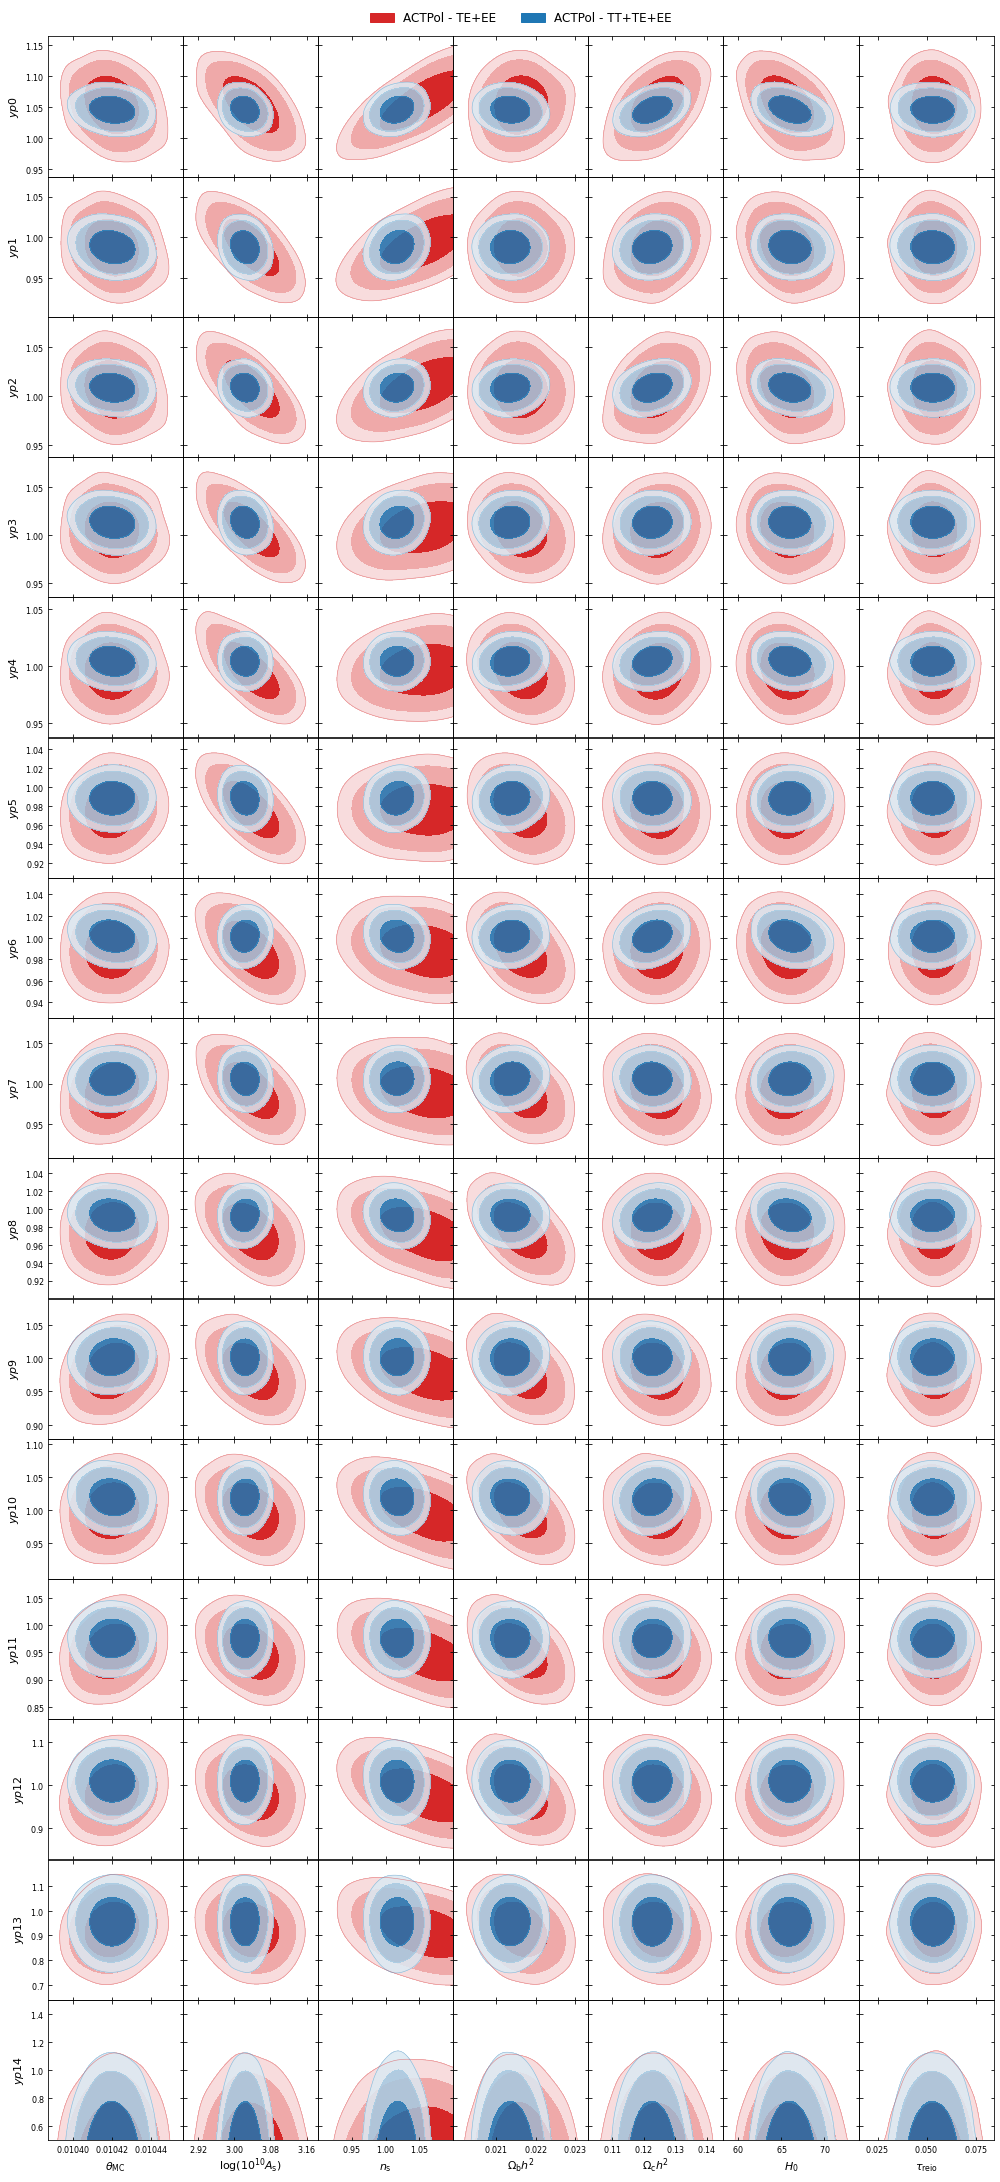

In [133]:
g.rectangle_plot(
    cosmo_params,
    nuisance_params,
    roots=samples,
    filled=True,
    legend_labels=mcmc_samples.keys(),
    colors=colors,
);

### Results

In [125]:
import ipywidgets as widgets

widgets.HBox(
    [
        widgets.Image(
            value=sample.getTable(
                limit=1, paramList=cosmo_params + nuisance_params + ["chi2"]
            )
            .tablePNG(dpi=150, bytesIO=True)
            .read()
        )
        for sample in samples
    ]
)

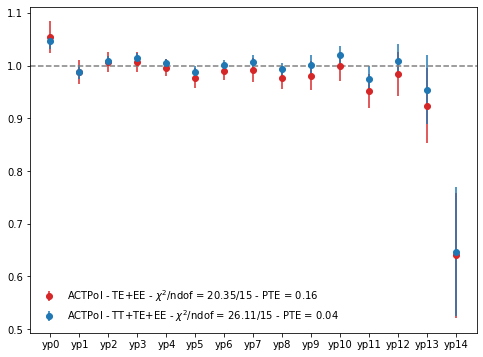

In [131]:
from scipy import stats

plt.figure(figsize=(8, 6))
x = np.arange(len(nuisance_params))
for i, sample in enumerate(samples):
    y = sample.mean(nuisance_params)
    yerr = sample.std(nuisance_params)
    chi2 = np.sum((y - 1) ** 2 / yerr ** 2)
    label = f"{list(mcmc_samples.keys())[i]} - $\chi^2$/ndof = {chi2:.2f}/15 - PTE = {stats.chi2.sf(chi2, 15):.2f}"
    plt.errorbar(x, y, yerr=yerr, fmt="o", label=label, color=colors[i])

plt.xticks(x, nuisance_params)
plt.axhline(1, ls="--", c="gray")
plt.legend(loc="lower left");
# nsigma = (y - 1)/yerr
# mask = nsigma > 3
# nsigma[mask]
# plt.text(x[mask], y[mask], "")